In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
import joblib

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/PTF/saved_single_run/"

In [2]:
#Market and option parameters as in section 4.2 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
corr= 0.3
tau = 1/52
T = 1/3
K = 100

mu = np.empty(20)
sigma = np.empty(20)
for i in range(0,10):
    mu[i] = mu[i+10] = (3+(i+1)/2)/100
    sigma[i] = sigma[i+10] = (15+(i+1))/100

cov_mat = np.empty((20,20))
for i in range(0,20):
    for j in range(0,20):
        if i != j:
            cov_mat[i,j] = corr
        else:
            cov_mat[i,j] = 1

C = np.linalg.cholesky(cov_mat)

#Confidence levels and parameters for Value-at-Risk, Expected Shortfall and GlueVaR
alpha_VaR = 0.995
alpha_ES = 0.99
alpha_Glue = 0.95
beta_Glue = 0.995
omega_Glue = np.array([1/3,1/3])

In [3]:
#Sizes for training set, validation set, test set, and set size for Monte Carlo estimation of the risk measures
M_1 = 1500000
M_2 = 500000
M_3 = 500000
#ignore N or N_2 in the following. Was kept just in case, but not used.
N_2 = 1

In [4]:
#Function for calculating simulated values of S_tau and simulated payoffs P_T
def data_gen(M,N):
    #simulate realisations of multivariate standard normal random variables
    Z = np.random.multivariate_normal(mean=np.full(20,0), cov=cov_mat, size=M)
    V = np.random.multivariate_normal(mean=np.full(20,0), cov=cov_mat, size=M*N)

    #simulate S_tau under P
    S_tau_pre = np.empty((M, 20))
    for j in range(0,20):
        S_tau_pre[:,j] = s_0 * np.exp( (mu[j]-0.5*sigma[j]**2)*tau + np.sqrt(tau)*sigma[j]*Z[:,j] )
    S_tau = np.tile(S_tau_pre, (N,1))
    np.random.shuffle(S_tau)

    #simulate S_T given S_tau under Q
    S_T = np.empty((N*M,20))
    for j in range(0,20):
        S_T[:,j] = S_tau[:,j] * np.exp( (r-0.5*sigma[j]**2)*(T-tau) + np.sqrt(T-tau)*sigma[j]*V[:,j] )

    #compute discounted option payoffs
    P_T_pre =np.empty((len(S_T), 20))
    for j in range(0,10):
        P_T_pre[:,j] = np.exp(-r*(T-tau)) * np.maximum(S_T[:,j]-K,0)
    for j in range(10,20):
        P_T_pre[:,j] = np.exp(-r*(T-tau)) * np.maximum(K-S_T[:,j],0)
    P_T = np.sum(P_T_pre, axis=1)
    return S_tau,P_T

#Function for the computation of GlueVaR
def GlueVaR(omega, L, alpha, beta):
    j_beta = int(len(L)*(1-beta))-1
    j_alpha = int(len(L)*(1-alpha))-1

    ES_beta = 1/(1-beta) * np.sum(L[0:j_beta-1])/len(L) + ( 1 - (j_beta-1)/((1-beta)*len(L)) )*L[j_beta]
    ES_alpha = 1/(1-alpha) * np.sum(L[0:j_alpha-1])/len(L) + ( 1 - (j_alpha-1)/((1-alpha)*len(L)) )*L[j_alpha]
    VaR_alpha = L[j_alpha]

    return omega[0]*ES_beta + omega[1]*ES_alpha + (1-omega[0]-omega[1])*VaR_alpha

In [5]:
#Calculate the risk factor S_tau and the corresponding simulated payoffs P_T
S_tau_train,P_T_train = data_gen(M=int(M_1/N_2),N=N_2)
S_tau_val,P_T_val = data_gen(M=M_2,N=1)
S_tau_test,P_T_test = data_gen(M=M_3,N=1)

In [6]:
#The higher the variance of one of these sets, the higher the MSE will be when computed for this set. Thus here the 
#validation error is expected to be lower than the training error but this does not necessarily indicate underfitting.
print(np.var(P_T_train),np.var(P_T_val),np.var(P_T_test))

1190.561102229855 1188.9295119331414 1188.871645787811


In [7]:
#define and compile neural network model, setup as in section 4.2 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(P_T_train)/len(P_T_train) )
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(20,)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#create a callback in order to save the model after each epoch s.t. they can be evaluated for the metrics a,b and c later
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "PTF_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

#train the model
hist = model.fit(x=S_tau_train, y=P_T_train, epochs=100, batch_size=10000, validation_data=(S_tau_val,P_T_val), callbacks=[checkpoints])

2021-11-02 13:18:03.223039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.4/lib64:/opt/bwhpc/common/compiler/gnu/10.2.0/lib:/opt/bwhpc/common/compiler/gnu/10.2.0/lib64:/opt/bwhpc/common/mpi/openmpi/4.1.1-gnu-10.2/lib:/opt/bwhpc/common/mpi/openmpi/4.1.1-gnu-10.2/lib64
2021-11-02 13:18:03.223068: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 13:18:03.223083: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uc2n464.localdomain): /proc/driver/nvidia/version does not exist
2021-11-02 13:18:03.223376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 1651.8138 - mse: 1651.8138 - val_loss: 1346.6642 - val_mse: 1346.6642
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 1222.6482 - mse: 1222.6482 - val_loss: 1217.6267 - val_mse: 1217.6267
Epoch 3/100
150/150 [==============================] - 1s 3ms/step - loss: 1189.4689 - mse: 1189.4689 - val_loss: 1179.9342 - val_mse: 1179.9342
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 1177.1321 - mse: 1177.1321 - val_loss: 1171.9794 - val_mse: 1171.9794
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 1171.2549 - mse: 1171.2549 - val_loss: 1167.3835 - val_mse: 1167.3835
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 1167.8363 - mse: 1167.8363 - val_loss: 1164.6464 - val_mse: 1164.6464
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 1165.6968 - mse: 1165.6967 - val_loss: 1162.8625 - val_

Plots of training and validation MSE of the neural network.

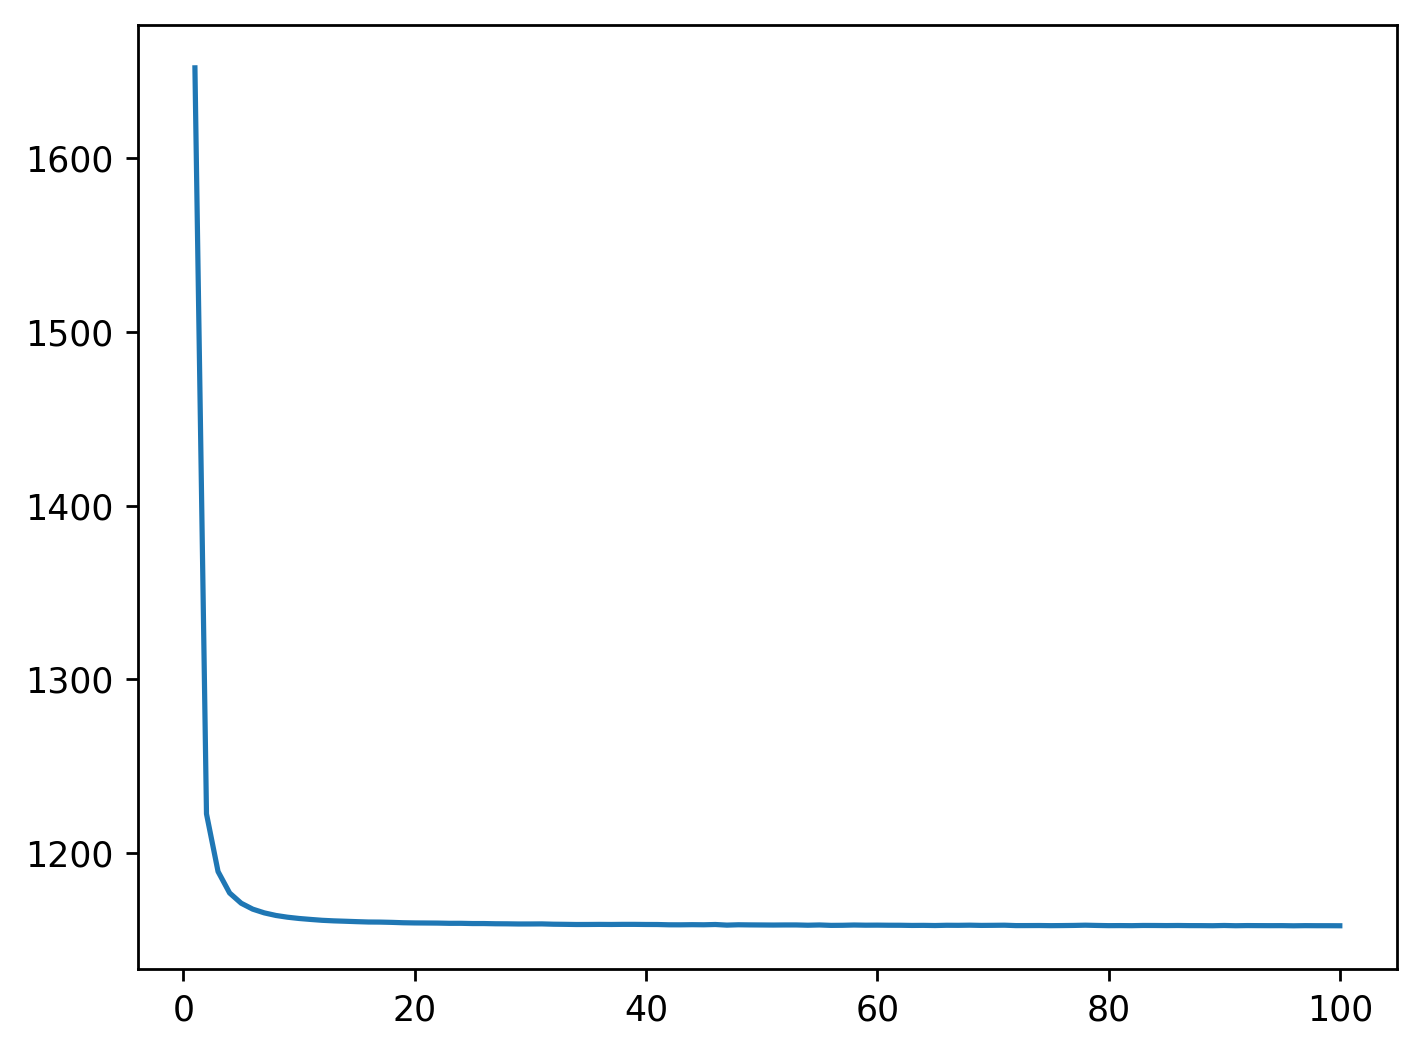

In [8]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), hist.history['mse'])

plt.show()

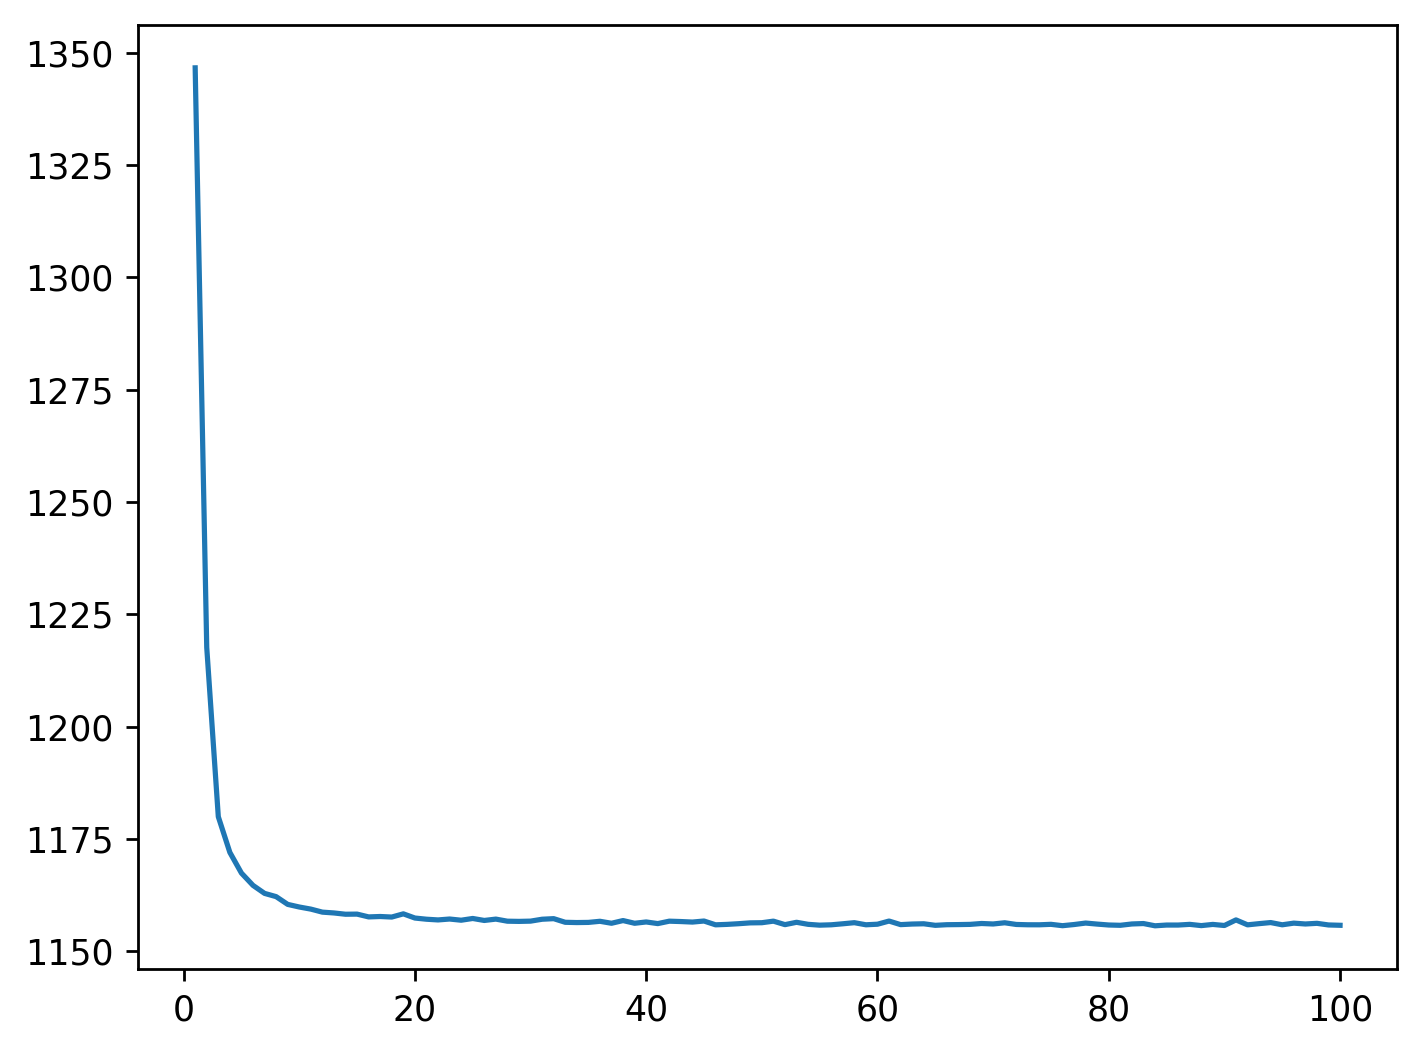

In [9]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), hist.history['val_mse'])

plt.show()

In [10]:
#perform a grid search in order to find the (approximately) best hyperparameter min_samples_leaf and max_features
#values that will be checked
max_features_list = [4,6,8]
min_samples_leaf_list = [20,30,40,50,60,70]
opt_param = np.full(2,0)
opt_score = np.inf

for max_features in max_features_list:
    for min_samples_leaf in min_samples_leaf_list:
        rfr_tuning = RandomForestRegressor(n_estimators=160, max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
        rfr_tuning.fit(X=S_tau_train, y=P_T_train)
        score = mean_squared_error(y_true=P_T_val, y_pred=rfr_tuning.predict(S_tau_val))
        print('min_samples_leaf: ', min_samples_leaf, ', max_features:',max_features, ', MSE: ', score)
        if score < opt_score:
            opt_param_RF = np.array([max_features,min_samples_leaf])
            opt_score = score
            print('New best!')

print('Best parameters found in grid search: ', opt_param_RF, ' with MSE ', opt_score)

min_samples_leaf:  20 , max_features: 4 , MSE:  1160.1532354651367
New best!
min_samples_leaf:  30 , max_features: 4 , MSE:  1159.9872641732863
New best!
min_samples_leaf:  40 , max_features: 4 , MSE:  1159.9352507396804
New best!
min_samples_leaf:  50 , max_features: 4 , MSE:  1160.1581250902973
min_samples_leaf:  60 , max_features: 4 , MSE:  1160.2241801491741
min_samples_leaf:  70 , max_features: 4 , MSE:  1160.2964532156907
min_samples_leaf:  20 , max_features: 6 , MSE:  1160.0395423023135
min_samples_leaf:  30 , max_features: 6 , MSE:  1159.7626654505727
New best!
min_samples_leaf:  40 , max_features: 6 , MSE:  1159.7018082983611
New best!
min_samples_leaf:  50 , max_features: 6 , MSE:  1159.572703372931
New best!
min_samples_leaf:  60 , max_features: 6 , MSE:  1159.923698493685
min_samples_leaf:  70 , max_features: 6 , MSE:  1159.7569503782338
min_samples_leaf:  20 , max_features: 8 , MSE:  1160.0770151376016
min_samples_leaf:  30 , max_features: 8 , MSE:  1159.6887644355083
min_

In [11]:
#trees will be added to the random forest consecutively in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', max_features=int(opt_param_RF[0]), min_samples_leaf=int(opt_param_RF[1]), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of training and validation MSE after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=S_tau_train, y=P_T_train)
    joblib.dump(rfr, filepath_wd + 'PTF_'+str(n)+'.joblib')
    mse_train_RF.append(((rfr.predict(S_tau_train)-P_T_train)**2).mean())
    mse_val_RF.append(((rfr.predict(S_tau_val)-P_T_val)**2).mean())
    print(n,'of',n_tree_steps[-1],'trees built')

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


Plots of training and validation MSE of the random forest.

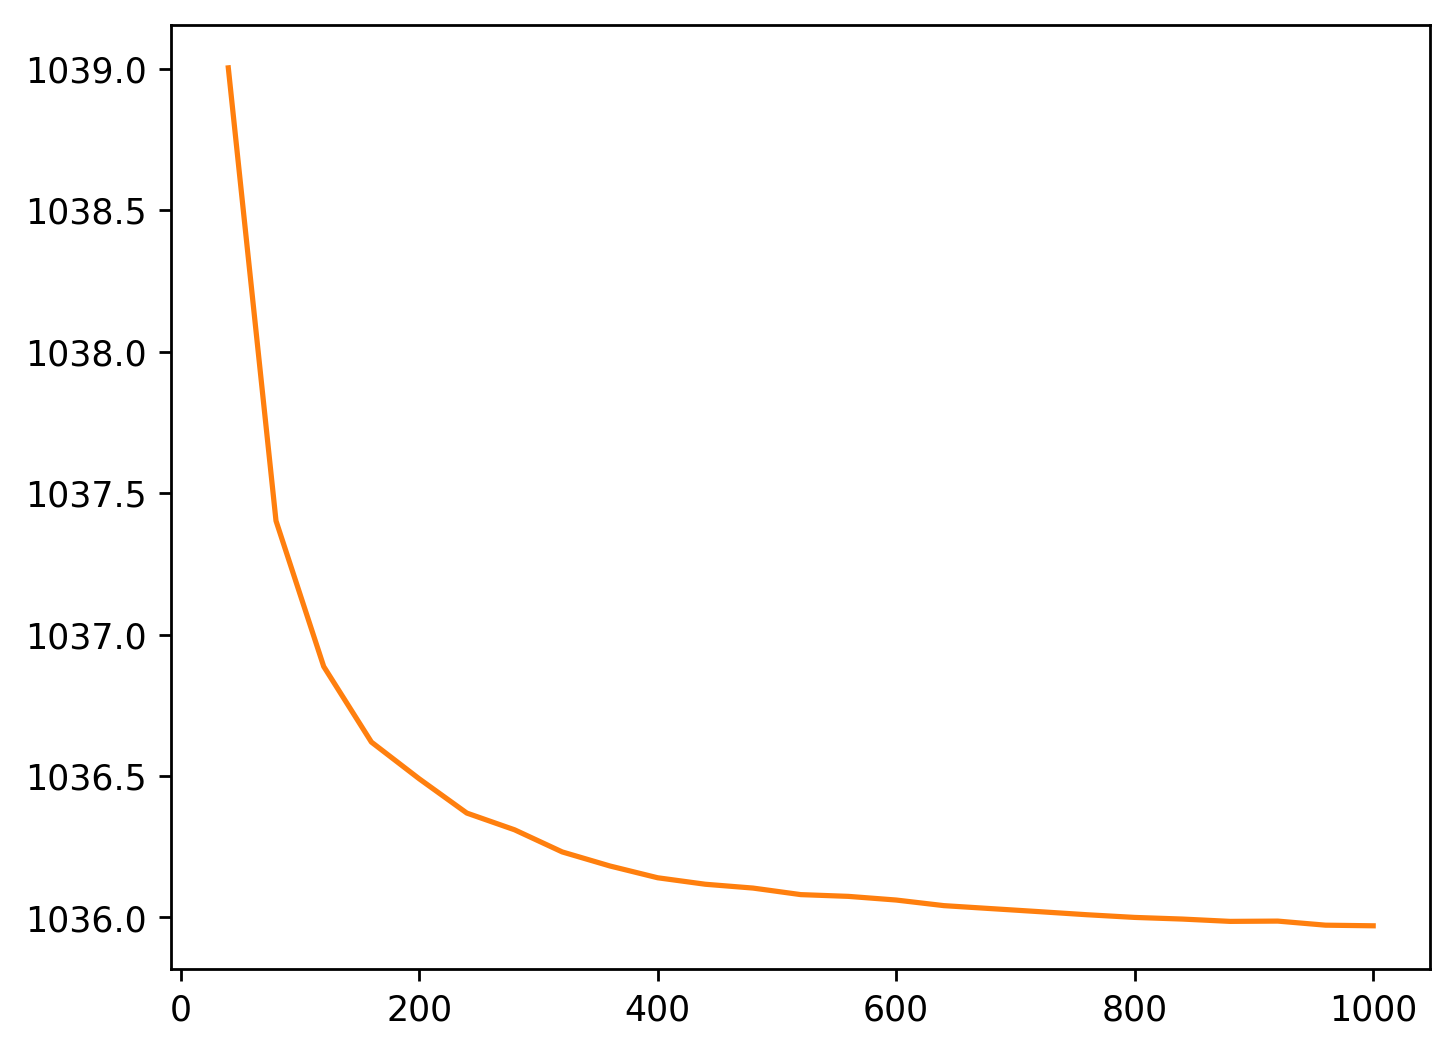

In [12]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, mse_train_RF, color='tab:orange')

plt.show()

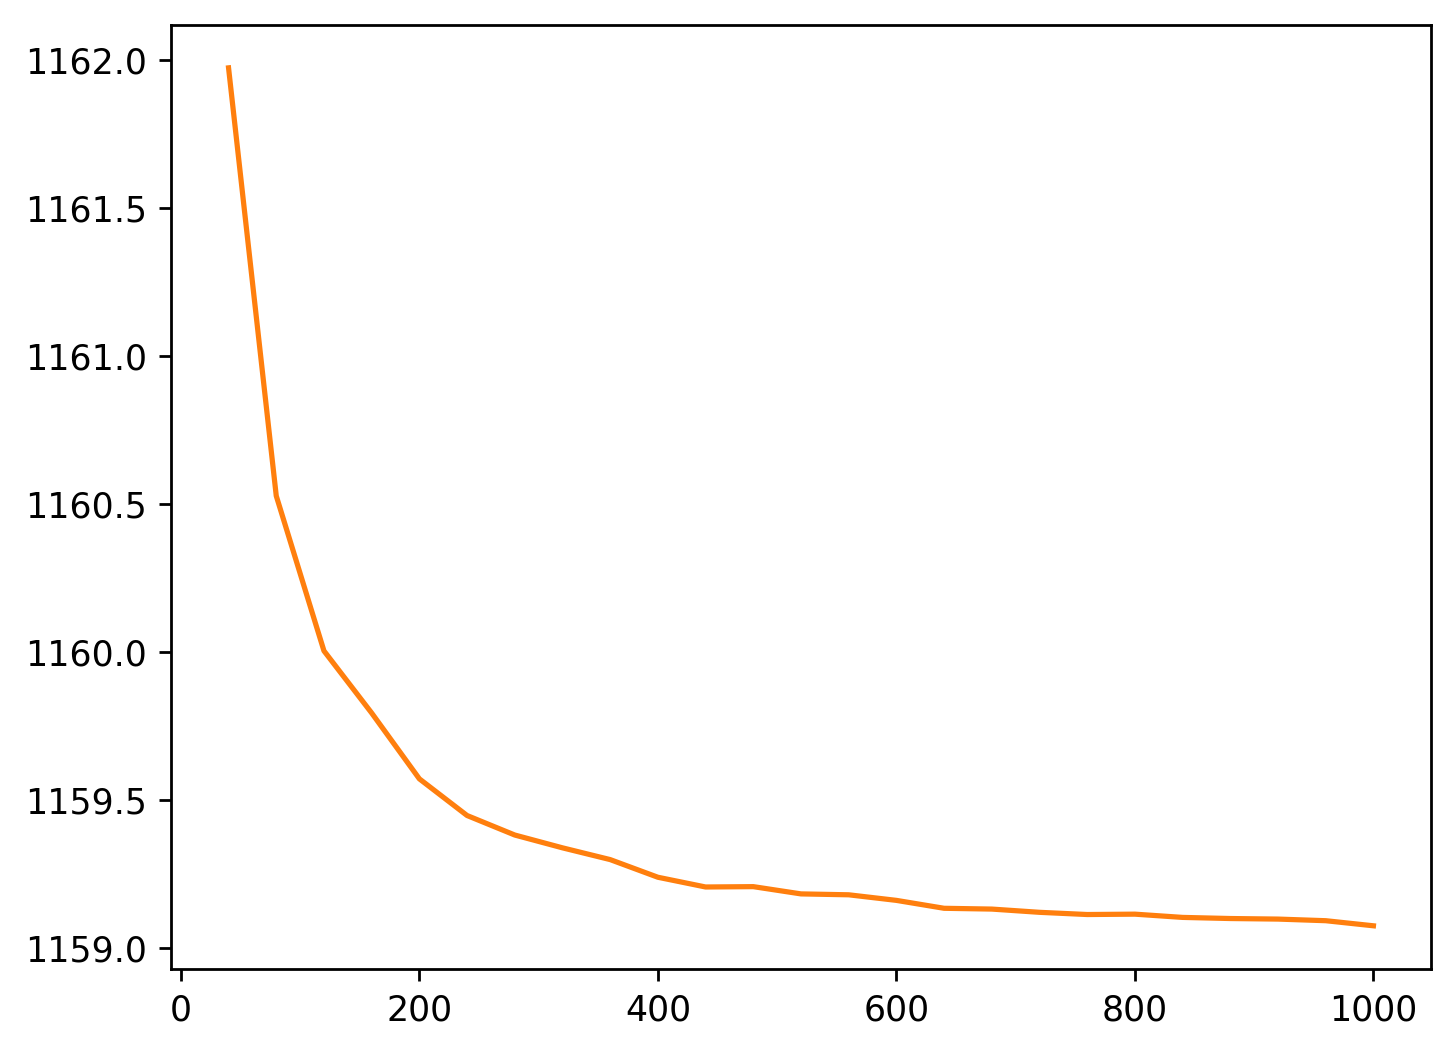

In [13]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, mse_val_RF, color='tab:orange')

plt.show()

In [14]:
#Calculating the parts of the test set that fall into B_1 and B_2
s_20_1 = s_0 * np.exp((mu[0:3]-0.5*sigma[0:3]**2)*tau + sigma[0:3]*np.sqrt(tau)*stats.norm.ppf(0.2, loc=0, scale=1))
s_80_1 = s_0 * np.exp((mu[9:12]-0.5*sigma[9:12]**2)*tau + sigma[9:12]*np.sqrt(tau)*stats.norm.ppf(0.8, loc=0, scale=1))
s_20_2 = s_0 * np.exp((mu[9:12]-0.5*sigma[9:12]**2)*tau + sigma[9:12]*np.sqrt(tau)*stats.norm.ppf(0.2, loc=0, scale=1))
s_80_2 = s_0 * np.exp((mu[0:3]-0.5*sigma[0:3]**2)*tau + sigma[0:3]*np.sqrt(tau)*stats.norm.ppf(0.8, loc=0, scale=1))

B_1 = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test[:,0:3] > s_20_1), np.apply_along_axis(np.all, axis=1, arr=S_tau_test[:,9:12] < s_80_1)) ) )
B_2 = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test[:,0:3] < s_80_2), np.apply_along_axis(np.all, axis=1, arr=S_tau_test[:,9:12] > s_20_2)) ) )

In [15]:
#loading the saved neural network models after every epoch
models_eval = []
for i in range(1,101):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "PTF_saved_epoch_" + str(i) + ".hdf5"))

In [16]:
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2 for the neural network
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []

for i in range(0,100):
    P_T_pred_tmp = models_eval[i].predict(S_tau_test)[:,0]

    ma_tmp = np.sum(P_T_pred_tmp - P_T_test)/len(P_T_test)
    metric_a_NN.append(ma_tmp)

    mb_tmp = np.sum((P_T_pred_tmp - P_T_test) * P_T_pred_tmp)/len(P_T_test)
    metric_b_NN.append(mb_tmp)

    mc_tmp = P_T_pred_tmp - P_T_test
    mc_1_tmp = np.sum(mc_tmp[B_1])/len(P_T_test)
    mc_2_tmp = np.sum(mc_tmp[B_2])/len(P_T_test)
    metric_c_B_1_NN.append(mc_1_tmp)
    metric_c_B_2_NN.append(mc_2_tmp)

Plots of metrics a, b, c with B_1 and B_2 with the evolving training process, i.e. on the $x$-axes of the following plots is the number of epochs.

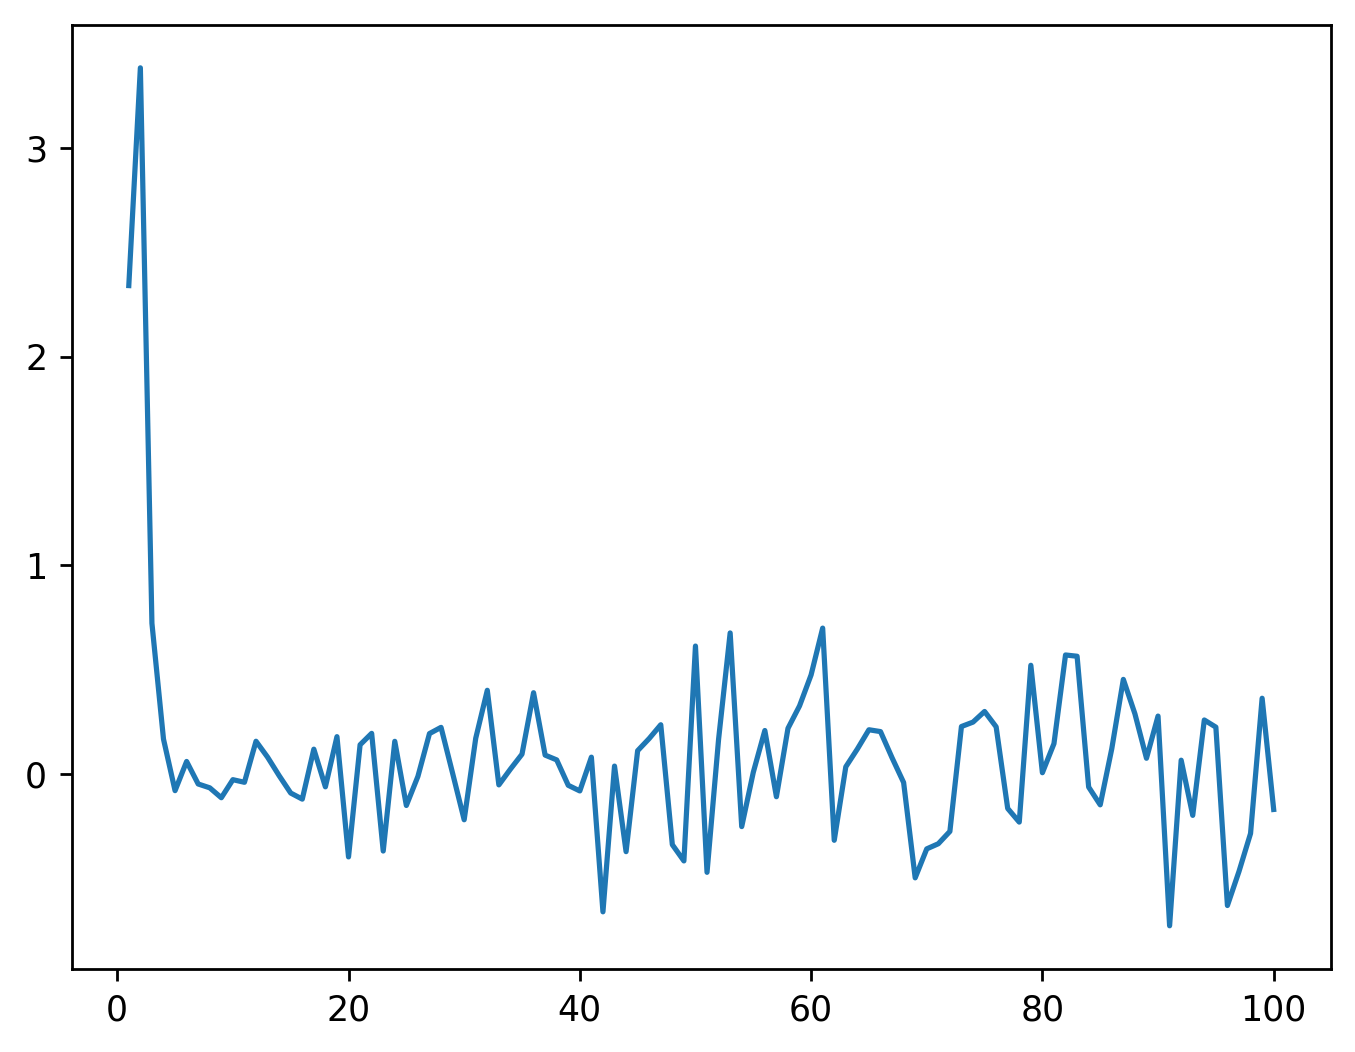

In [17]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), metric_a_NN)

plt.show()

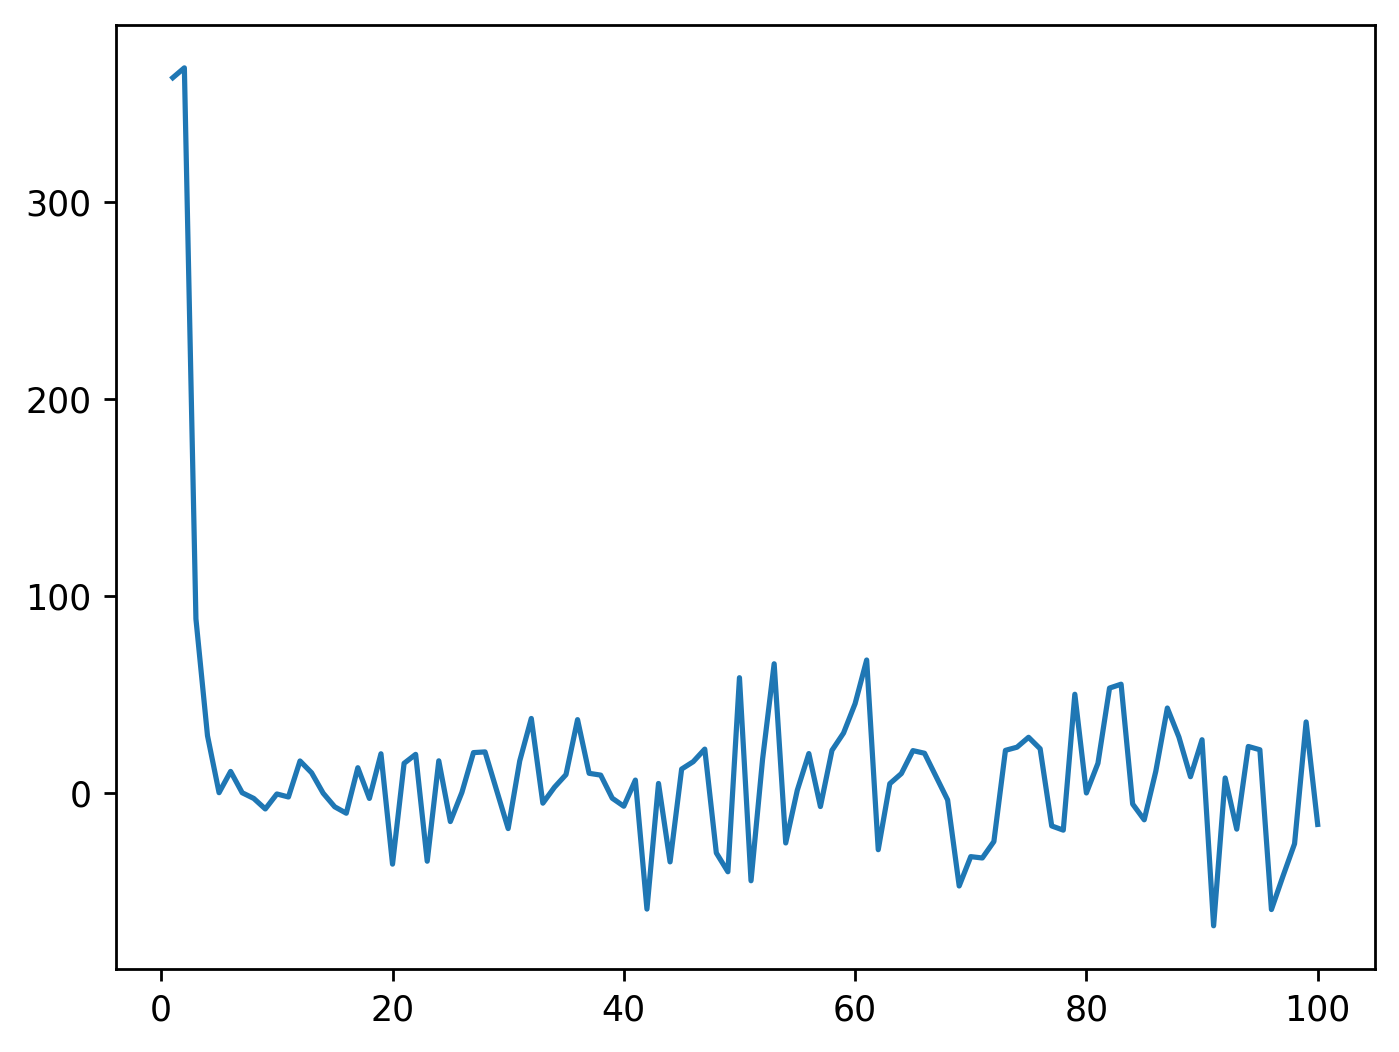

In [18]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), metric_b_NN)

plt.show()

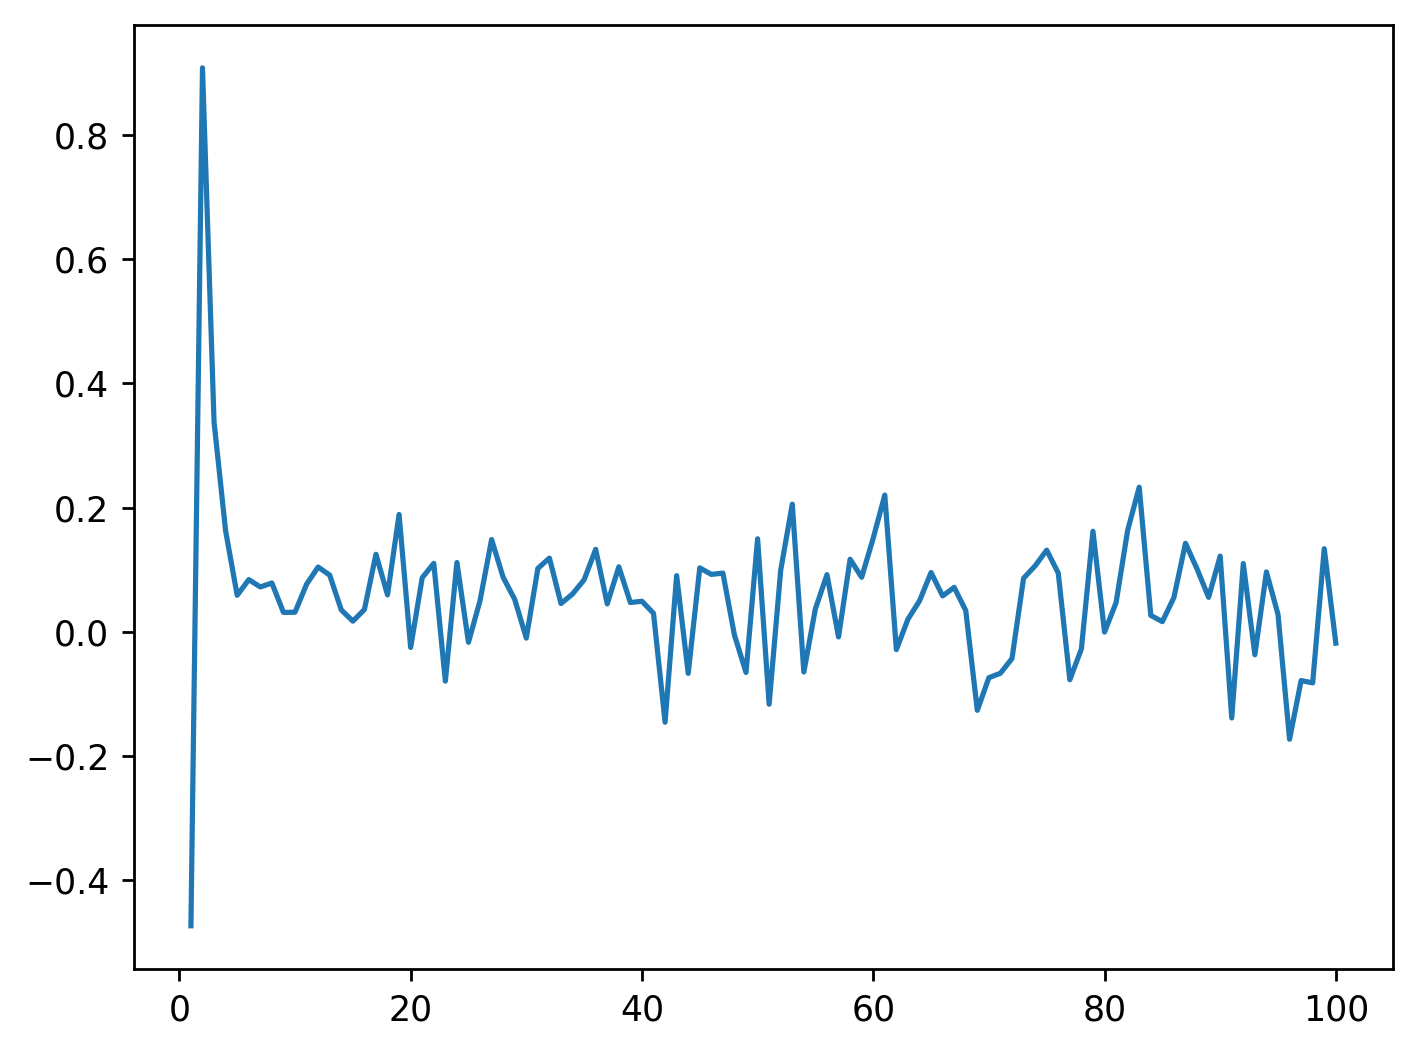

In [19]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), metric_c_B_1_NN)

plt.show()

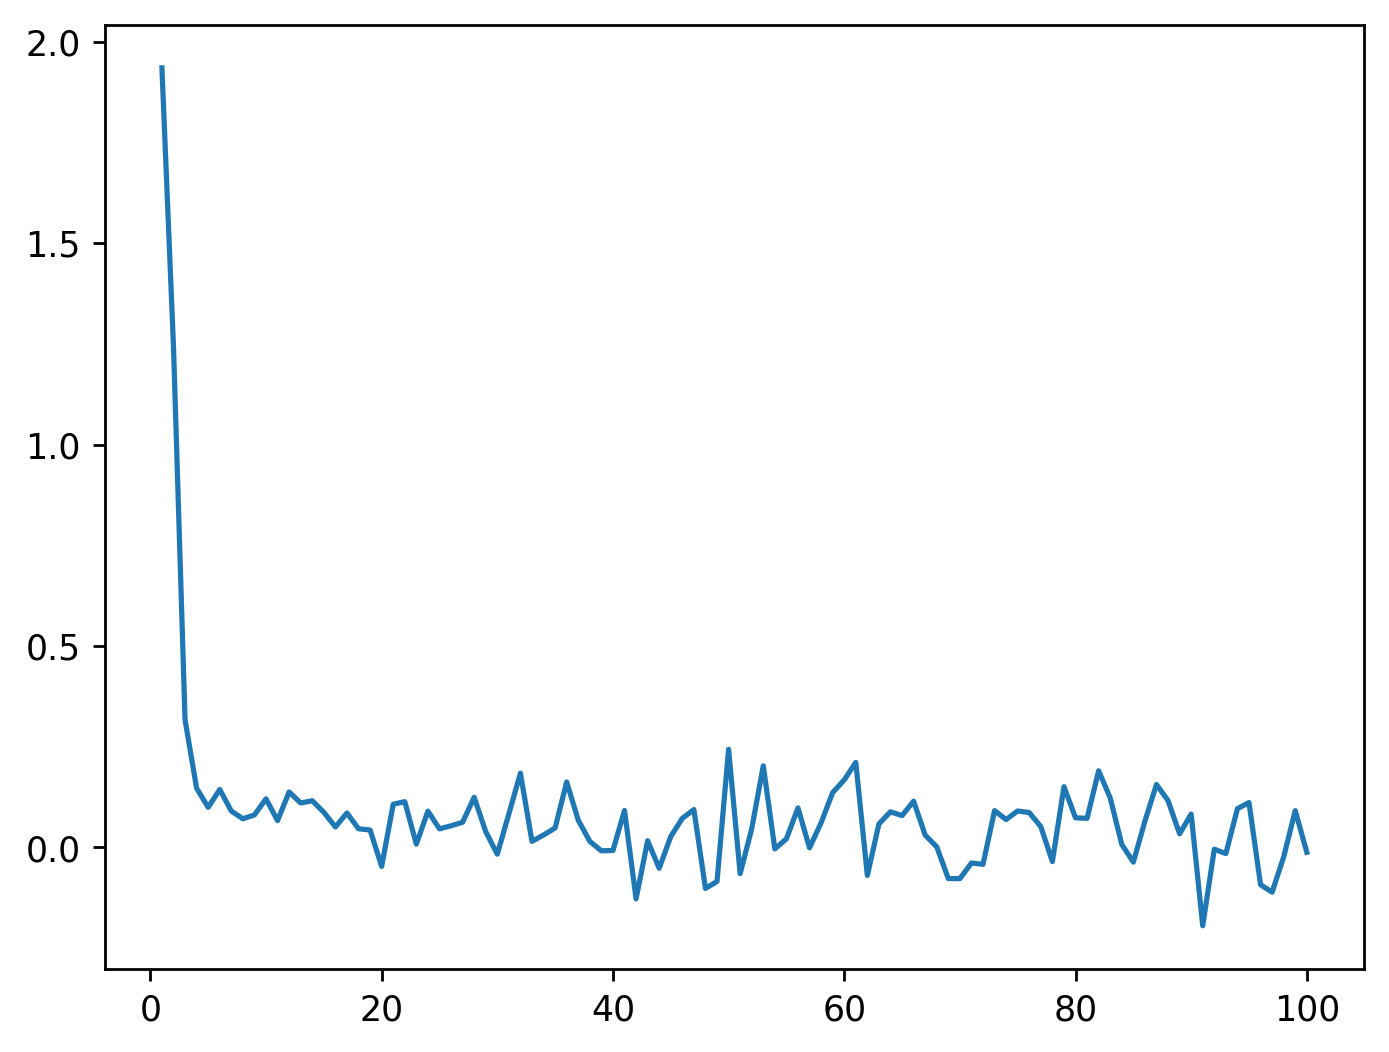

In [20]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,101), metric_c_B_2_NN)

plt.show()

In [21]:
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2 for the random forest
metric_a_RF = []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

for n in n_tree_steps:
    P_T_pred_tmp = joblib.load(filepath_wd + 'PTF_'+str(n)+'.joblib').predict(S_tau_test)

    ma_tmp = np.sum(P_T_pred_tmp - P_T_test)/len(P_T_test)
    metric_a_RF.append(ma_tmp)

    mb_tmp = np.sum((P_T_pred_tmp - P_T_test) * P_T_pred_tmp)/len(P_T_test)
    metric_b_RF.append(mb_tmp)

    mc_tmp = P_T_pred_tmp - P_T_test
    mc_1_tmp = np.sum(mc_tmp[B_1])/len(P_T_test)
    mc_2_tmp = np.sum(mc_tmp[B_2])/len(P_T_test)
    metric_c_B_1_RF.append(mc_1_tmp)
    metric_c_B_2_RF.append(mc_2_tmp)

Plots of metrics a, b, c with B_1 and B_2 with the evolving training process, i.e. on the $x$-axes of the following plots is the number of added trees in steps of 40.

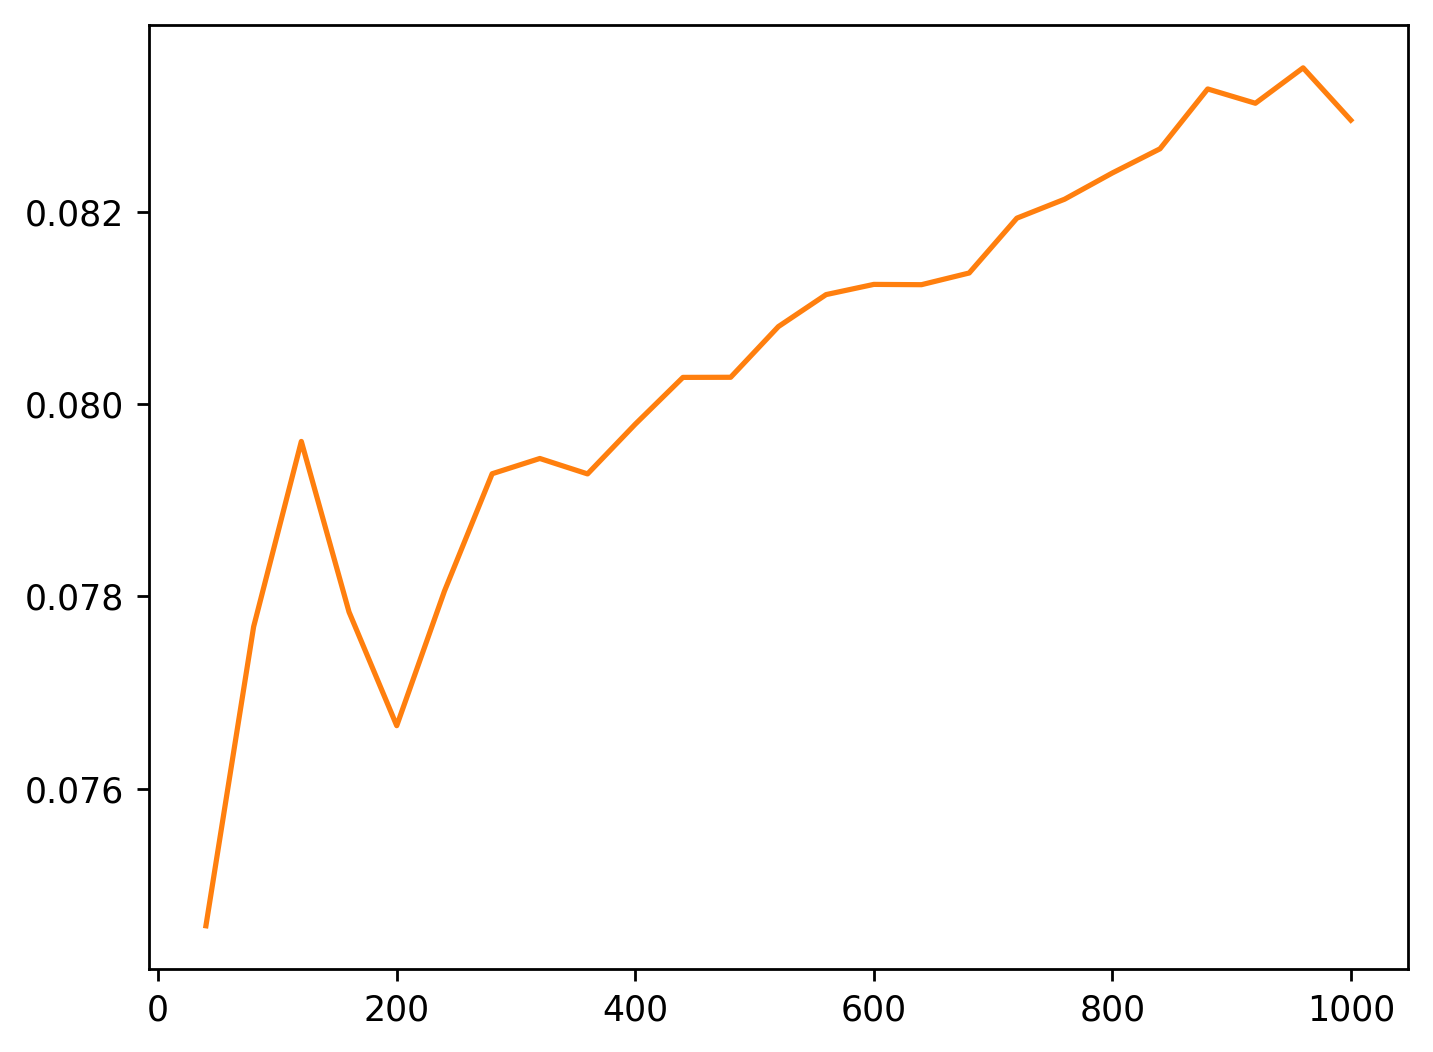

In [22]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_a_RF, color='tab:orange')

plt.show()

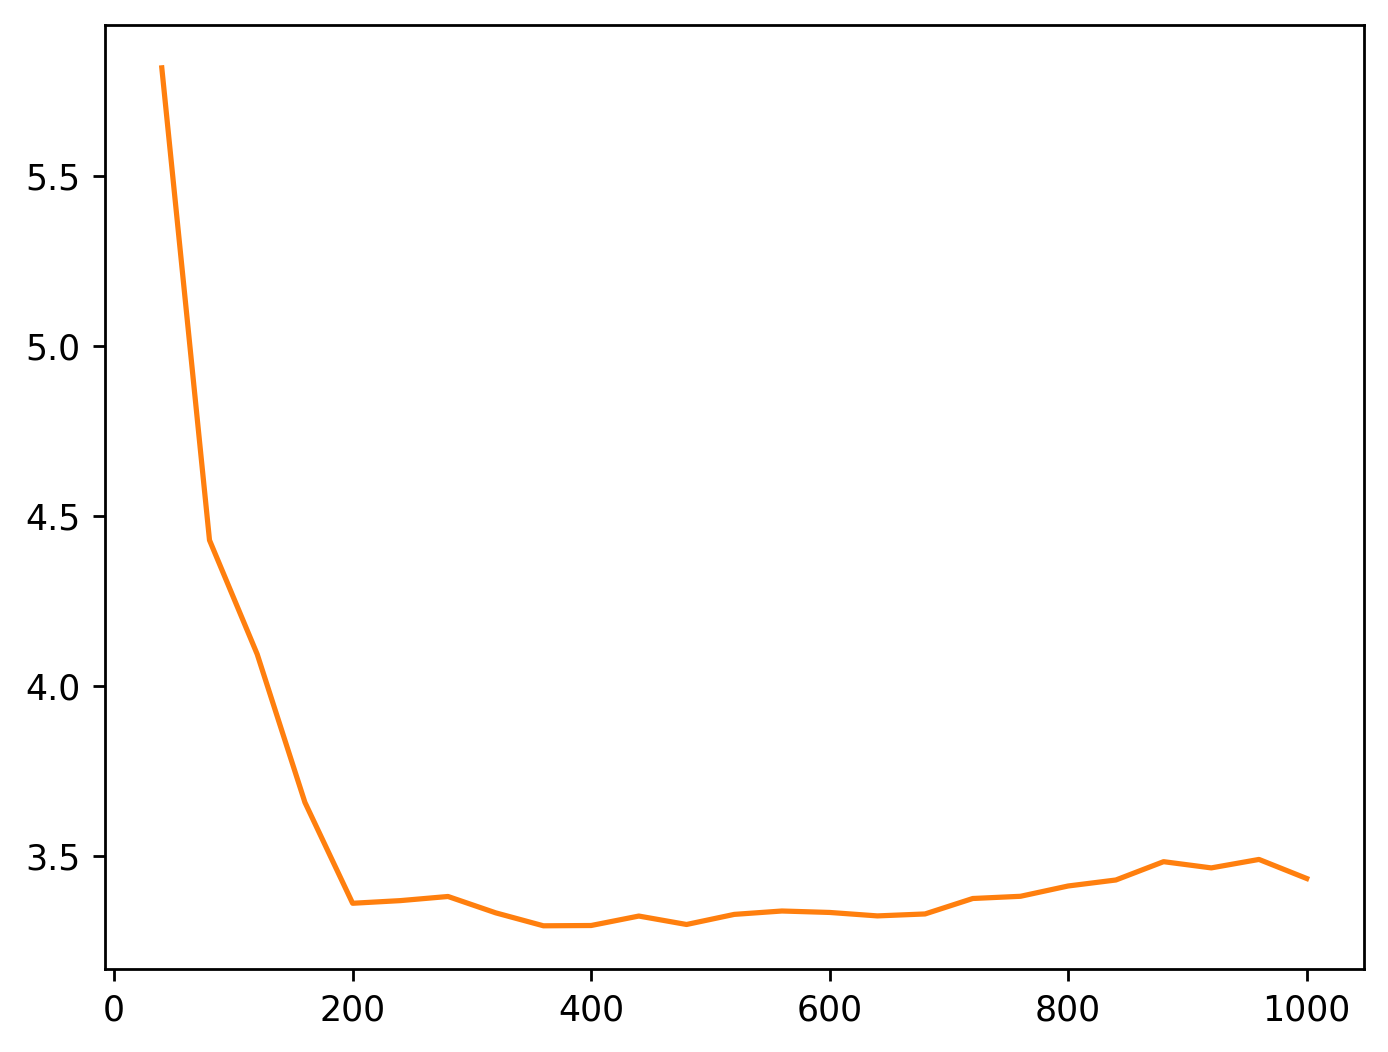

In [23]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_b_RF, color='tab:orange')

plt.show()

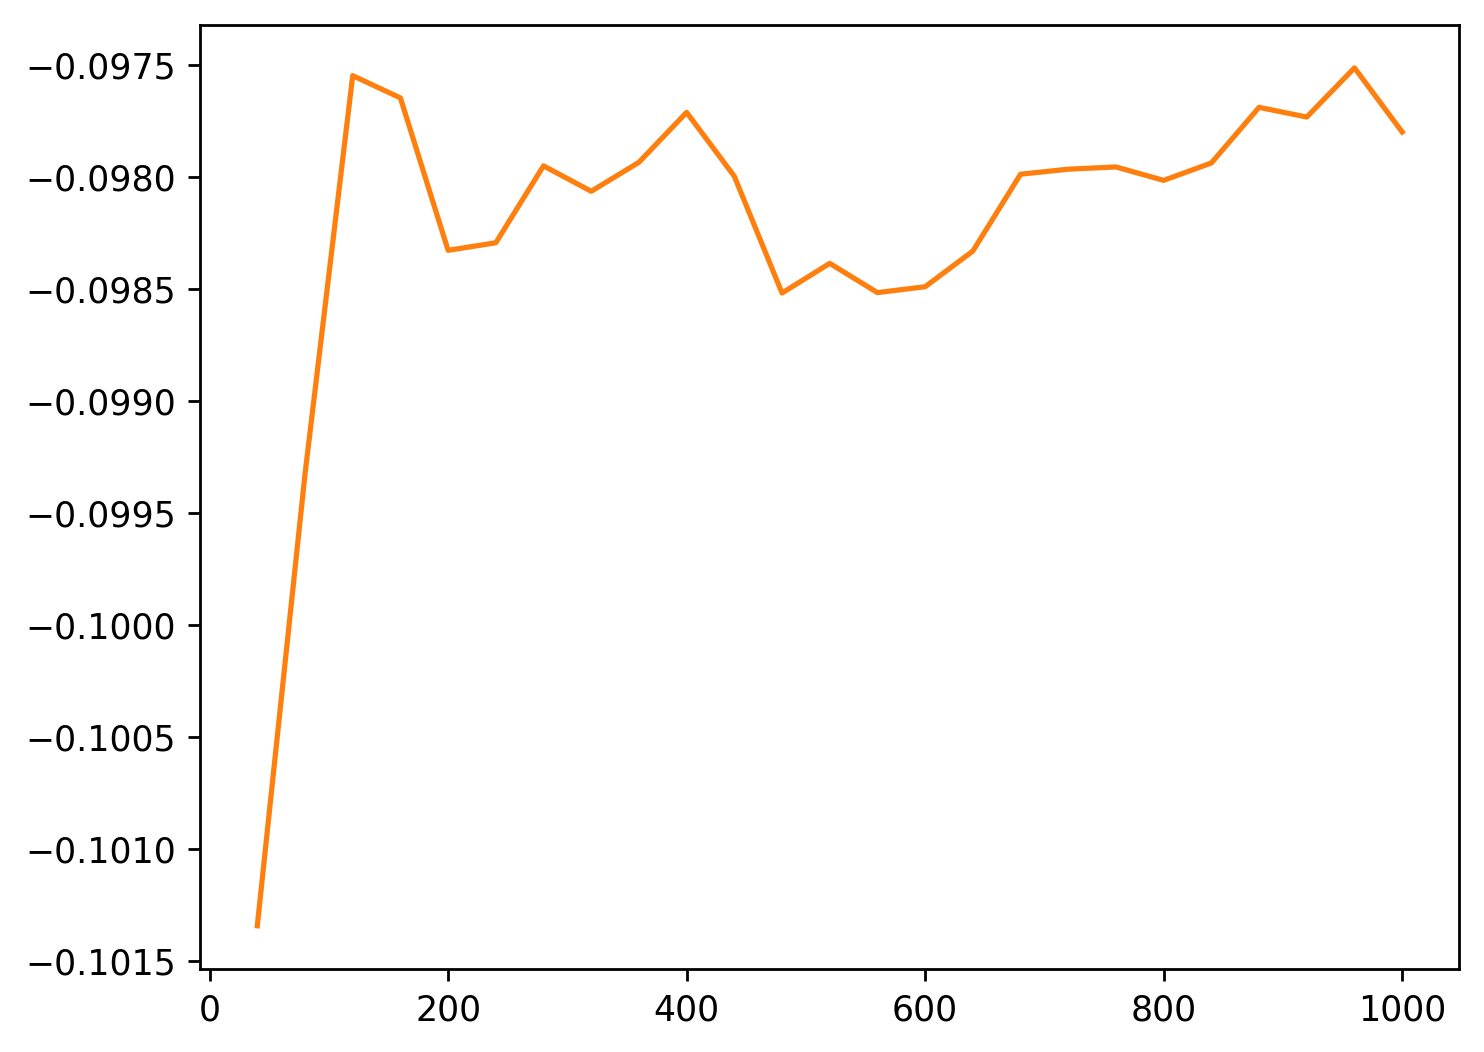

In [24]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_c_B_1_RF, color='tab:orange')

plt.show()

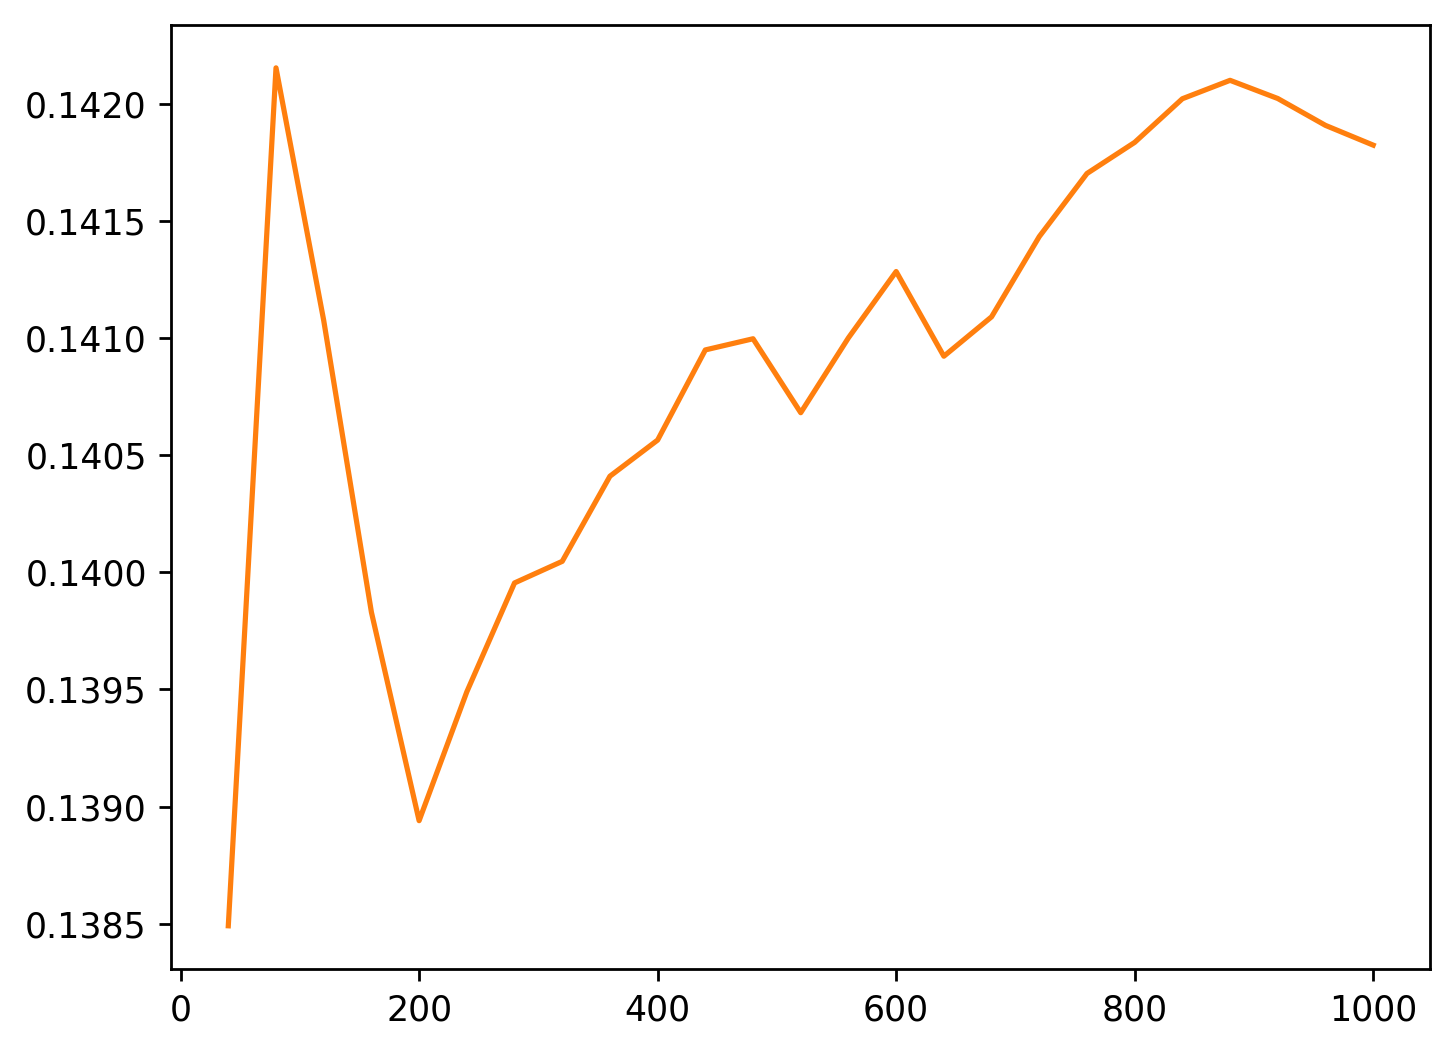

In [25]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_c_B_2_RF, color='tab:orange')

plt.show()

In [26]:
#Simulation of S_\tau
S_tau_MC,P_T_MC = data_gen(M=500000,N=1)

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
i = 500000/step_number

In [27]:
#initialisation of risk measure estimators
VaR_hat_NN = []
ES_hat_NN = []
GlueVaR_hat_NN = []
VaR_hat_RF = []
ES_hat_RF = []
GlueVaR_hat_RF = []

#Prediction of total of all option prices
P_T_pred_NN = model.predict(S_tau_MC)[:,0]
P_T_pred_RF = np.ndarray.tolist(rfr.predict(S_tau_MC))

for n in range(1,step_number+1):
    #computation of risk measure estimators
    #sort observations
    L_NN = np.sort(P_T_pred_NN[0:int(n*i)])[::-1]
    L_RF = np.sort(P_T_pred_RF[0:int(n*i)])[::-1]

    #Value-at-Risk
    j_VaR = int(n*i*(1-alpha_VaR))-1
    VaR_hat_NN.append(L_NN[j_VaR])
    VaR_hat_RF.append(L_RF[j_VaR])

    #Expected Shortfall
    j_ES = int(n*i*(1-alpha_ES))-1
    ES_hat_NN.append( 1/(1-alpha_ES) * np.sum(L_NN[0:j_ES-1])/(n*i) + ( 1 - (j_ES-1)/((1-alpha_ES)*n*i) )*L_NN[j_ES])
    ES_hat_RF.append( 1/(1-alpha_ES) * np.sum(L_RF[0:j_ES-1])/(n*i) + ( 1 - (j_ES-1)/((1-alpha_ES)*n*i) )*L_RF[j_ES])
    
    #GlueVaR
    GlueVaR_hat_NN.append(GlueVaR(omega=omega_Glue, L=L_NN, alpha=alpha_Glue, beta=beta_Glue))
    GlueVaR_hat_RF.append(GlueVaR(omega=omega_Glue, L=L_RF, alpha=alpha_Glue, beta=beta_Glue))

Plots of the risk measure estimators calculated in the stepwise procedure.

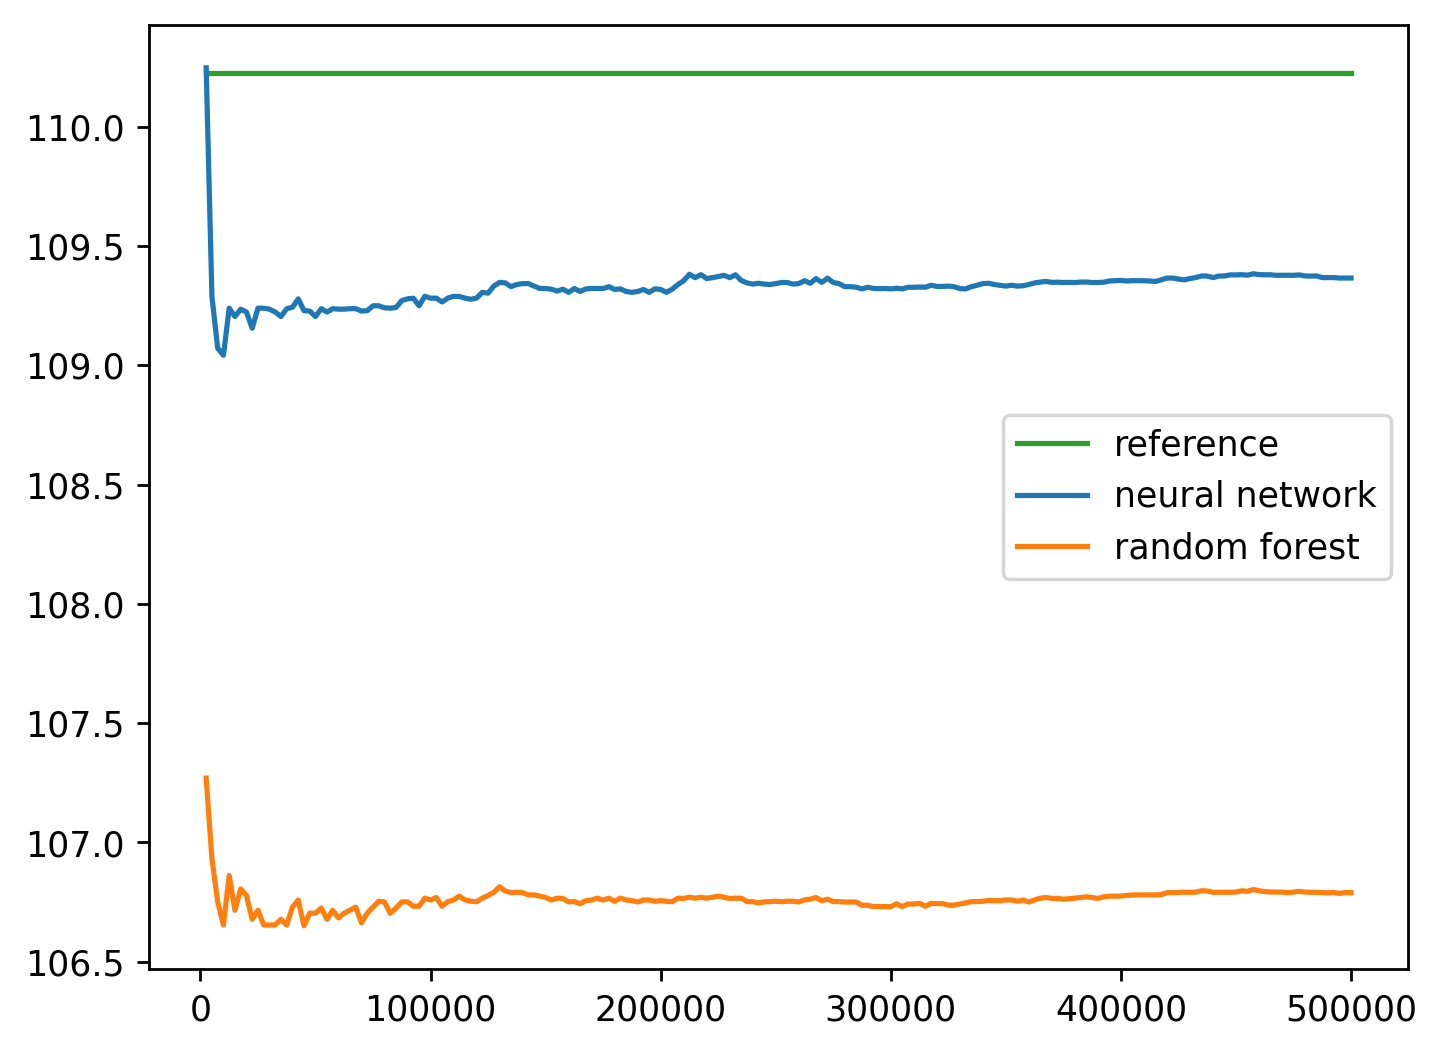

In [28]:
steps = np.linspace(i, 500000, step_number)

plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, np.full(step_number, 110.227), color='tab:green')
plt.plot(steps, VaR_hat_NN, color='tab:blue')
plt.plot(steps, VaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])

plt.show()

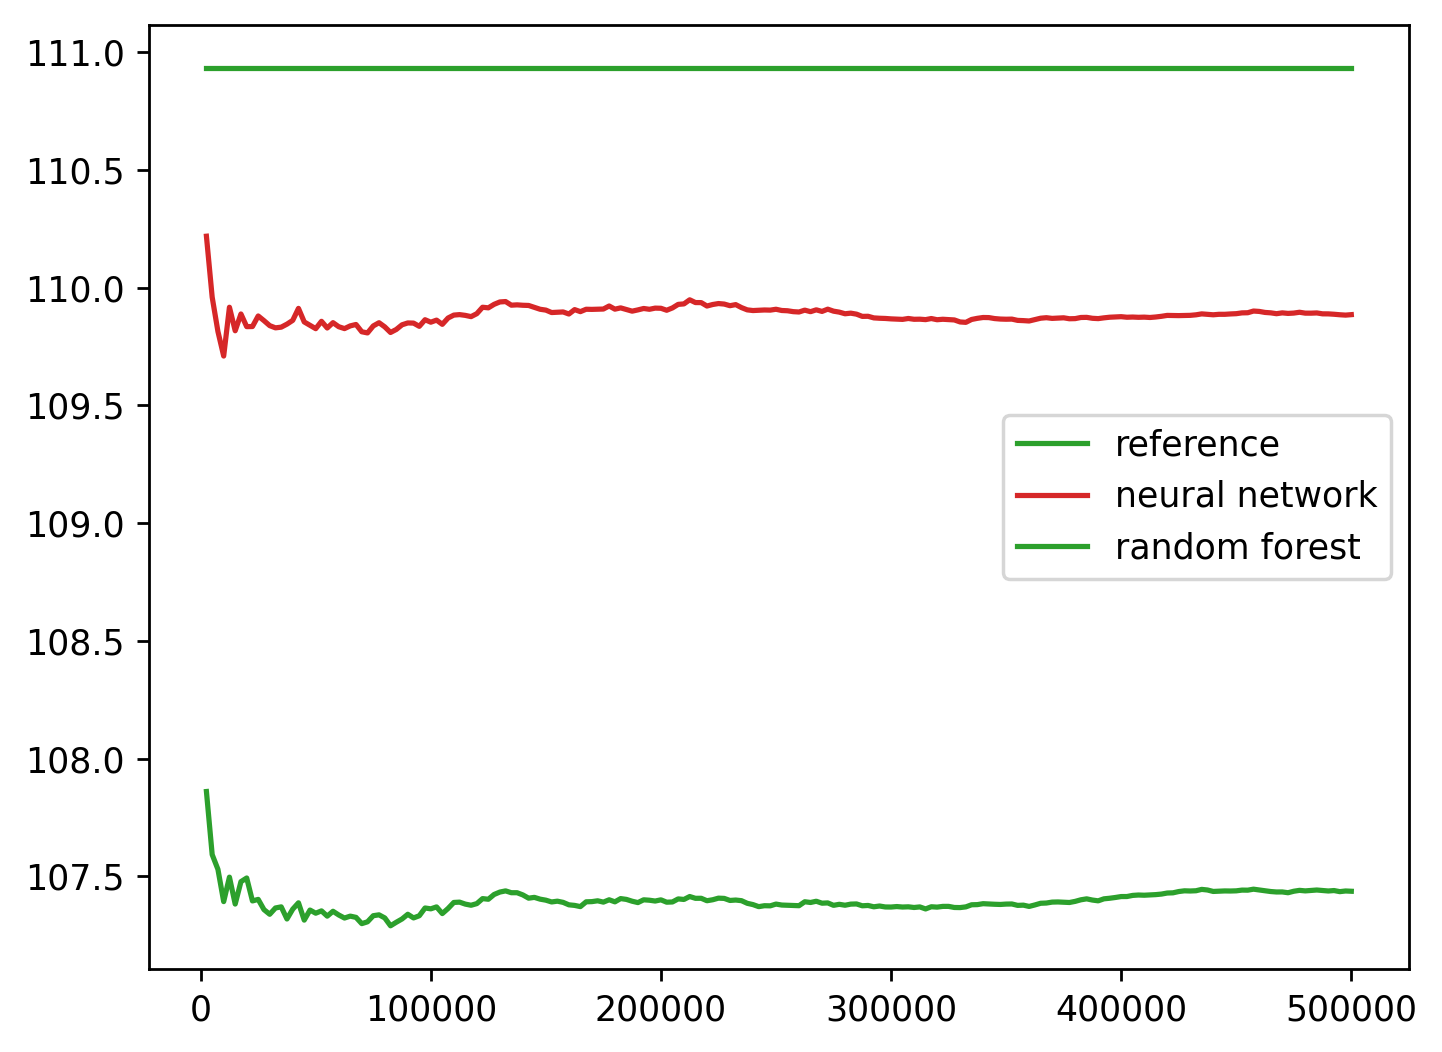

In [29]:
steps = np.linspace(i, 500000, step_number)

plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, np.full(step_number, 110.934), color='tab:green')
plt.plot(steps, ES_hat_NN, color='tab:red')
plt.plot(steps, ES_hat_RF, color='tab:green')

plt.legend(['reference','neural network','random forest'])

plt.show()

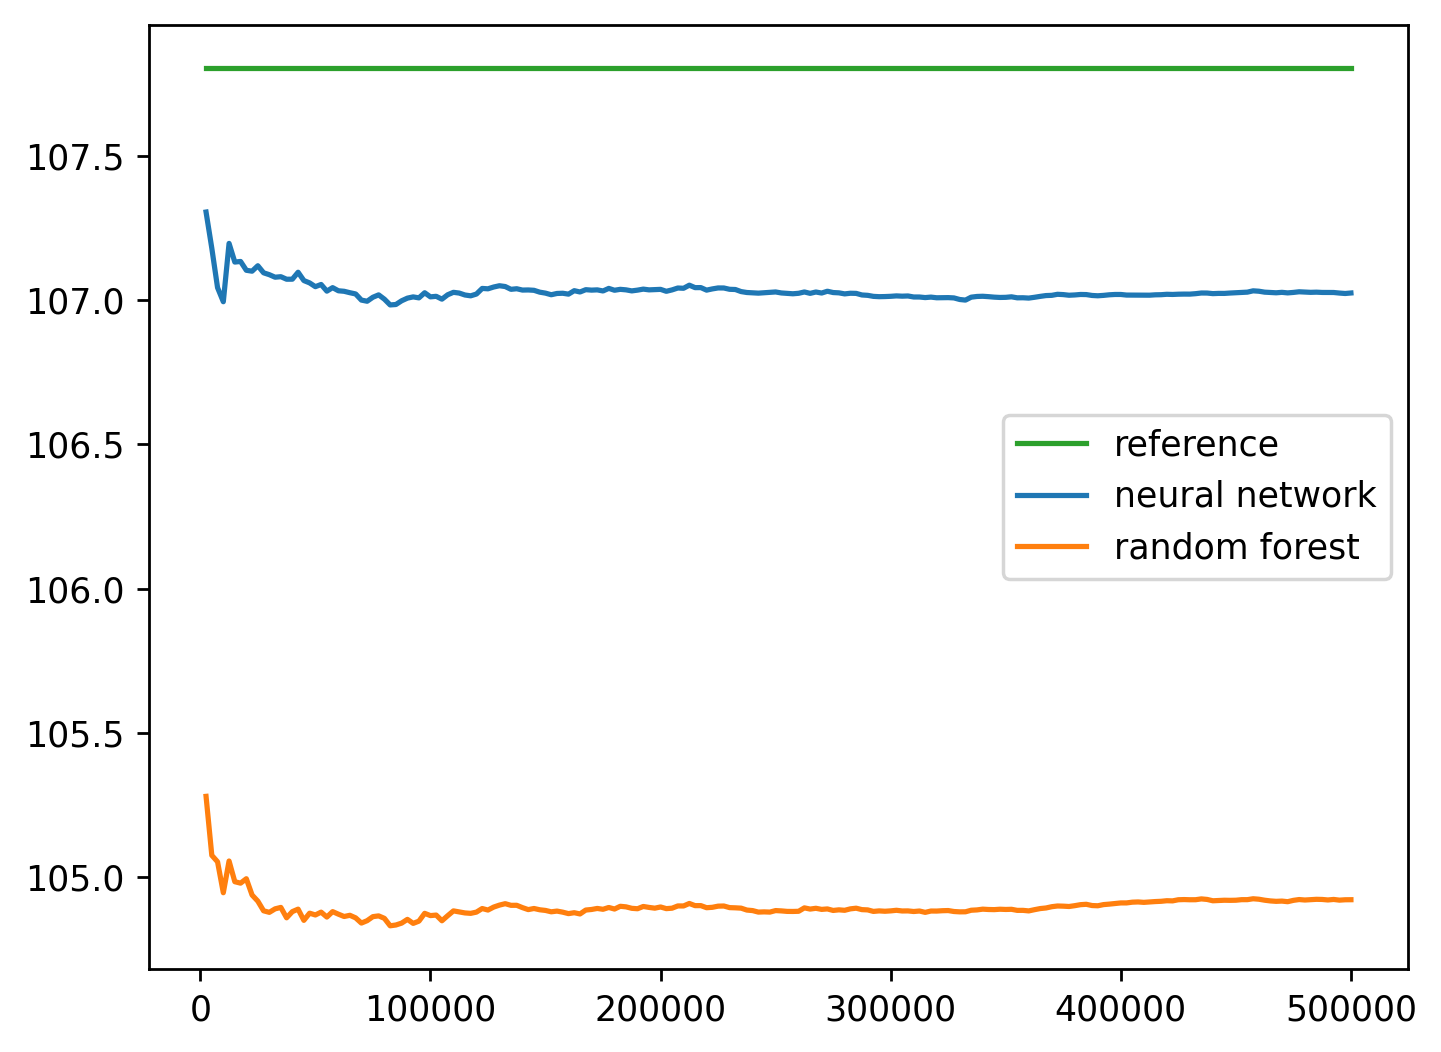

In [30]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, np.full(step_number, 107.806), color='tab:green')
plt.plot(steps, GlueVaR_hat_NN, color='tab:blue')
plt.plot(steps, GlueVaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])

plt.show()

In [31]:
#Saving the computed risk measure estimators such that they can be compared to estimators produced with usage of the importance sampling procedure in another notebook (single_run_eval.ipynb)
joblib.dump(VaR_hat_NN, filepath+'VaR_hat_NN.joblib')
joblib.dump(ES_hat_NN, filepath+'ES_hat_NN.joblib')
joblib.dump(GlueVaR_hat_NN, filepath+'GlueVaR_hat_NN.joblib')
joblib.dump(VaR_hat_RF, filepath+'VaR_hat_RF.joblib')
joblib.dump(ES_hat_RF, filepath+'ES_hat_RF.joblib')
joblib.dump(GlueVaR_hat_RF, filepath+'GlueVaR_hat_RF.joblib')

['/pfs/data5/home/ul/ul_student/ul_ynv73/PTF/saved_mix/GlueVaR_hat_RF.joblib']